Iterative FFT stress calculation method of

> A PHASE-FIELD MODEL FOR EVOLVING MICROSTRUCTURES WITH STRONG ELASTIC INHOMOGENEITY  
> S. Y. HU and L. Q. CHEN  
> _Acta mater._ **49** (2001) 1879–1890

In [1]:
%matplotlib inline

In [2]:
import fipy as fp

In [3]:
from fipy import numerix as nmx

In [4]:
from scipy import fftpack

p. 1883:
> We introduce a circular precipitate with composition 0.947 and a radius of R = 10 in a square domain of matrix (256×256) with composition 0.053.

In [5]:
nx = 256

In [6]:
Lx = 256.

In [7]:
mesh = fp.Grid2D(nx=nx, ny=nx, Lx=Lx, Ly=Lx)

In [8]:
dX = fp.CellVariable(mesh=mesh, name=r"$\delta X$")

In [9]:
dX.setValue(0.947 - 0.053, where=(mesh.x - Lx / 2.)**2 + (mesh.y - Lx / 2.)**2 <= 10**2)

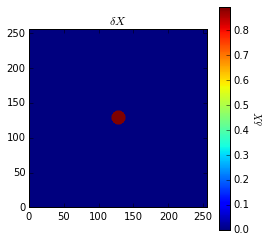

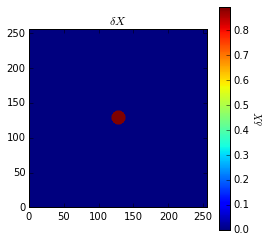

In [10]:
fp.Viewer(vars=dX)

## reciprocal lattice vector

In [11]:
g = fp.CellVariable(mesh=mesh, name=r"$\vec{g}$", rank=1)

**Note:** Can this be done with a view instead of reshaping twice?

In [12]:
g.value.shape = (-1, g.mesh.nx, g.mesh.nx)

In [13]:
g.value[0] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)

In [14]:
g.value[1] = nmx.fft.fftfreq(n=mesh.nx, d=mesh.dx)[..., nmx.newaxis]

In [15]:
g.value.shape = (-1, g.mesh.numberOfCells)

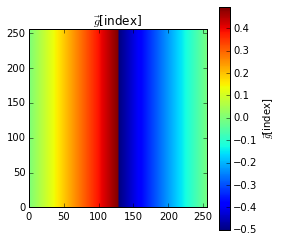

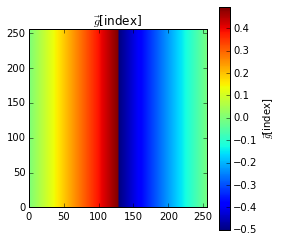

In [16]:
fp.Viewer(vars=g[0])

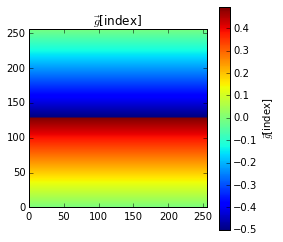

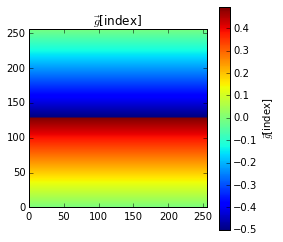

In [17]:
fp.Viewer(vars=g[1])

## stiffness tensor

From Section 4.1 (note, the paper calls this elastic constant $\lambda_{ijkl}$ for some reason):

In [18]:
C11 = 300
C12 = 100
C44 = 100

In [76]:
C11prime = 150
C12prime = 50
C44prime = 50

In [19]:
C = nmx.zeros((2, 2, 2, 2))

In [98]:
Cprime = nmx.zeros((2, 2, 2, 2))

For a cubic material:  
$\begin{align*}
C_{11} = C_{22} &\rightarrow C_{1111} = C_{2222} \\
C_{12} = C_{21} &\rightarrow C_{1122} = C_{2211} \\
C_{44} = C_{55} = C_{66} &\rightarrow C_{1212} = C_{1221} = C_{2112} = C_{2121}
\end{align*}$

All other $C_{ij} = 0$.

In [20]:
C[0][0][0][0] = C[1][1][1][1] = C11
C[0][0][1][1] = C[1][1][0][0] = C12
C[0][1][0][1] = C[0][1][1][0] = C[1][0][0][1] = C[1][0][1][0] = C44

In [182]:
Cprime[0][0][0][0] = Cprime[1][1][1][1] = C11prime
Cprime[0][0][1][1] = Cprime[1][1][0][0] = C12prime
Cprime[0][1][0][1] = Cprime[0][1][1][0] = Cprime[1][0][0][1] = Cprime[1][0][1][0] = C44prime

p 1881, below Eq. (11):  
$(G^{-1}(\vec{g}))_{ik} = g^2 \lambda^\circ_{ijkl} n_j n_l$

Recasting in our notation:   
$(G^{-1}(\vec{g}))_{ik} = C^\circ_{ijkl} g_j g_l$

In [21]:
Gik_inv = nmx.einsum('ijkl,j...,l...->ik...', C, g.value, g.value)

We can't invert the (zero) CW element, but we also don't care what it is

In [22]:
Gik_inv[..., 0] = nmx.eye(2,2)

(Slow) inversion of tensor field. Opportunity to use [Wheeler's Riemann utilities](https://github.com/usnistgov/fipy/blob/riemann/fipy/tools/smallMatrixVectorOps.py)?

In [23]:
Gik = nmx.rollaxis(nmx.array(map(nmx.linalg.inv, nmx.rollaxis(Gik_inv, axis=2))), axis=0, start=3) 

In [24]:
epsilon0 = 0.05

In [25]:
eigenstrain = epsilon0 * nmx.eye(2,2)

In [26]:
eigenstress = nmx.einsum('ijkl...,kl...->ij...', C, eigenstrain)

p. 1881 below Eq. (11):
> $\nu^0_k(\vec{g})$ and $\delta X(\vec{g})$ are Fourier transforms of $u^0_k(\vec{r})$ and $\delta X(\vec{r})$, respectively

(**Note:** every other symbol remains the same and simply changes its argument from $\vec{r}$ to $\vec{g}$ when it Fourier transforms, but displacment magically mutates from $u$ to $\nu$?

In [27]:
dXg = fftpack.fftn(dX.value.reshape((nx, nx))).reshape(-1)

p. 1881, Eq. (11):  
> $\nu^0_k(\vec{g}) = -i G_{ik}(\vec{g}) g_j \sigma^\circ_{ij} \delta X(\vec{g})$

In [234]:
ug0 = -1j * nmx.einsum('ik...,j...,ij...->k...', Gik, g, eigenstress) * dXg

p. 1882, Eq. (18):
> $\delta \epsilon_{ij}(\vec{r}) 
= \frac{1}{(2\pi)^3}\int \frac{i}{2}\left[\nu_i(\vec{g})g_j + \nu_j(\vec{g})g_i\right]
e^{i\vec{g}\cdot\vec{r}}\,d^3\vec{g}$

In [235]:
straing = 0.5j * (nmx.einsum('i...,j...->ij...', ug0, g) + nmx.einsum('j...,i...->ij...', ug0, g))

In [236]:
strain0 = fftpack.ifftn(straing.reshape((2, 2, nx,nx)), axes=(-2, -1)).reshape((2, 2, -1))

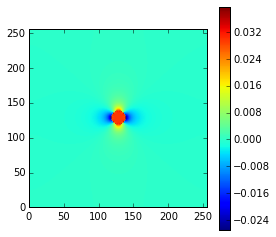

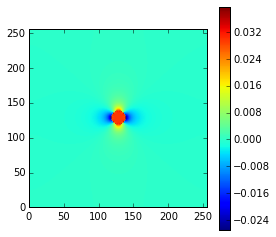

In [237]:
fp.Viewer(vars=fp.CellVariable(mesh=mesh, value=strain0[0][0].real))

p. 1881, Eq. (4):  
> $\sigma^\mathrm{el}_{ij}(\vec{r}) 
= \left[\lambda^\circ_{ijkl} + \lambda'_{ijkl}\delta X(\vec{r})\right]
\left[\epsilon_{kl}(\vec{r}) - \epsilon^\circ_{kl}(\vec{r})\right]$

Neglecting the ihomogenous elastic constants and converting to our notation:

$\sigma^\mathrm{el}_{ij}(\vec{r}) 
= C^\circ_{ijkl}
\left[\epsilon_{kl}(\vec{r}) - \epsilon^\circ_{kl} \delta X(\vec{r})\right]$


In [238]:
stress0 = nmx.einsum('ijkl...,kl...->ij...', C, strain0 - eigenstrain[..., nmx.newaxis] * dX.value)

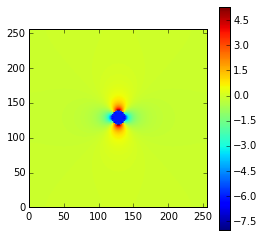

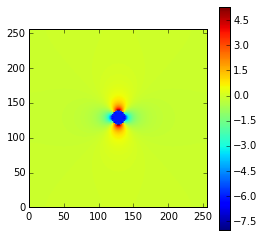

In [239]:
fp.Viewer(vars=fp.CellVariable(mesh=mesh, value=stress0[0][0].real))

## Comparison to analytical values

In [240]:
halfx = mesh.x[nx//2]

In [241]:
mask = (mesh.y == halfx).value

In [242]:
x = mesh.x[mask].value

In [243]:
sigma11 = stress0[0][0][mask].real

In [244]:
sigma22 = stress0[1][1][mask].real

### Eschelby solutions

#### plain strain

From:
> _Micromechanics of Defects in Solids_  
> Toshio Mura  
> 1987 Kluwer Academic Publishers

p. 80, secion 11, Eschelby's solution, Elliptic cylinder ($a_3 \rightarrow 0$)

For $a_1 = a_2 = a$:  
$I_1 = I_2 = 2\pi \qquad I_3 = 0$  
$I_{12} = 4\pi / 4a^2 = \pi / a^2 \qquad 
3 I_{11} = 4\pi / a^2 - \pi / a^2 = 3\pi / a^2 \rightarrow I_{11} = \pi / a^2$  
$I_{22} = \pi / a^2 \qquad I_{13} = I_{23} = I_{33} = 0$

In [245]:
lamda = C12
mu = C44
nu = lamda / (2.*(lamda + mu))

In [246]:
sigma0 = -mu / (1 - nu) * epsilon0

In [247]:
sigma11esch = sigma0 * (((x - Lx/2.)**2 <= 10**2) + nmx.NaN * ((x - Lx/2.)**2 > 10**2))

In [248]:
sigma11esch = nmx.where(((x - Lx/2.)**2 <= 10**2), sigma0, nmx.NaN)

### Visualization

In [249]:
from matplotlib import pyplot as plt

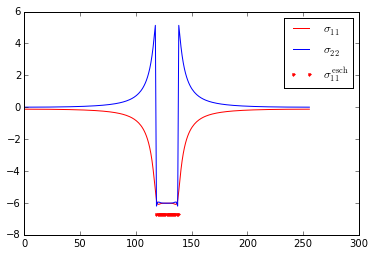

In [250]:
s11, = plt.plot(x, sigma11, 'r-', label=r"$\sigma_{11}$")
s22, = plt.plot(x, sigma22, 'b-', label=r"$\sigma_{22}$")
s11esch, = plt.plot(x, sigma11esch, 'r.', label=r"$\sigma_{11}^\mathrm{esch}$")
plt.legend(handles=[s11, s22, s11esch])

## Higher order

p. 1881, Eq. (14):  
$u^n_k(\vec{g}) = -i G_{ik}(\vec{g}) g_j \left[
\left(\sigma^\circ_{ij}-C'_{ijkl}\bar{\epsilon}_{kl}\right) \delta X(\vec{g})
+ C'_{ijkl}\epsilon^\circ_{kl}\left\{\left(\delta X(\vec{r})\right)^2\right\}_g
- C'_{ijkl}\left(\delta X(\vec{r})\frac{\partial u^{n-1}_k(\vec{r})}{\partial r_l}\right)_g
\right]$

In [251]:
homostrain = nmx.zeros((2,2))

In [252]:
dX2g = fftpack.fftn((dX**2).value.reshape((nx, nx))).reshape(-1)

In [257]:
def highOrder(n):
    dudr = fftpack.ifftn(-1j * nmx.einsum('i...,j...->ij...', ug[n-1], g), axes=(-2, -1)).reshape(2, 2, -1)
    dXdudrg = fftpack.fftn((dX*dudr).value.reshape((2, 2, nx, nx)), axes=(-2, -1)).reshape(2, 2, -1)
#    dXdudrg = fftpack.fftn((dX*u[n-1].grad).value.reshape((2, 2, nx, nx)), axes=(-2, -1)).reshape(2, 2, -1)

    stressg = ((eigenstress - nmx.einsum('ijkl...,kl...->ij...', Cprime, homostrain))[..., nmx.newaxis] * dXg
               + nmx.einsum('ijkl...,kl...->ij...', Cprime, eigenstrain)[..., nmx.newaxis] * dX2g
               - nmx.einsum('ijkl...,kl...->ij...', Cprime, dXdudrg))

    ugn = -1j * nmx.einsum('ik...,j...,ij...->k...', Gik, g, stressg)

#    un = fftpack.ifftn(ugn.reshape((2, nx, nx)), axes=(-2, -1)).reshape(2, -1)
    
    straingn = 0.5j * (nmx.einsum('i...,j...->ij...', ugn, g) + nmx.einsum('j...,i...->ij...', ugn, g))

    strainn = fftpack.ifftn(straingn.reshape((2, 2, nx,nx)), axes=(-2, -1)).reshape((2, 2, -1))

    stressn = nmx.einsum('ijkl...,kl...->ij...', C + Cprime * dX, strainn - eigenstrain[..., nmx.newaxis] * dX.value)
    
    return ugn, strainn, stressn

In [266]:
ug = []
strain = []
stress = []

In [267]:
#u.append(fp.CellVariable(mesh=mesh, value=fftpack.ifftn(ug.reshape((2, nx, nx)), axes=(-2,-1)).reshape(2, -1)))
ug.append(ug0)
strain.append(strain0)
stress.append(stress0)

In [268]:
for n in range(1,10):
    ugn, strainn, stressn = highOrder(n)
    ug.append(fp.CellVariable(mesh=mesh, value=un))
#    u.append(fp.CellVariable(mesh=mesh, value=un))
    strain.append(strainn)
    stress.append(stressn)

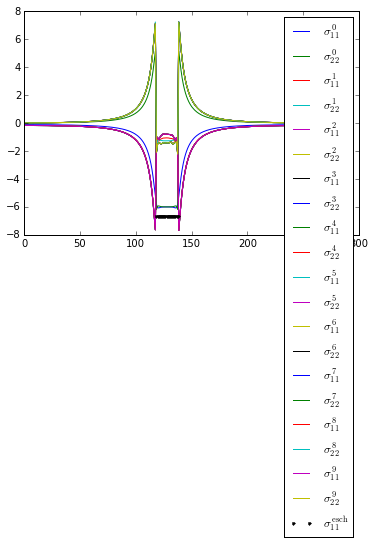

In [275]:
handles = []
for n in range(len(strain)):
    s11, = plt.plot(x, stress[n][0][0][mask].real, label=r"$\sigma^%d_{11}$" % n)
    s22, = plt.plot(x, stress[n][1][1][mask].real, label=r"$\sigma^%d_{22}$" % n)
    handles.append(s11)
    handles.append(s22)
s11esch, = plt.plot(x, sigma11esch, 'k.', label=r"$\sigma_{11}^\mathrm{esch}$")
handles.append(s11esch)
plt.legend(handles=handles)